<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log
import numpy as np

from nlp.dataset import plot_frequencies, plot_roc
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace
from torch.optim import Adam

In [4]:
DS_ITEM_COUNTS_PATH = './nlp/data/2_grams_wikicorpus_concat_1.5%.npz'
DS_NAME = 'wikicorpus'

In [3]:
### get ngrams for wiki. we only used 10% of the data as dataset is huge. only run if necessary... ###

#get_ngram_counts('wikicorpus', limit_prop=0.1, n=2, tokens_key='sentence', name='tagged_en')

# actual bigrams frequency

there are 811477 bigrams


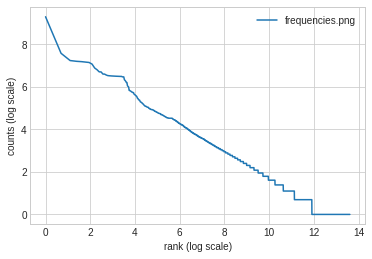

In [17]:
import numpy as np
counts = np.load(DS_ITEM_COUNTS_PATH)['y']
print(f'there are {len(counts)} bigrams')
plot_frequencies(counts, 'rank (log scale)', 'counts (log scale)', 'frequencies.png')

In [9]:
indices = np.argsort(counts)
bigrams = np.load(DS_ITEM_COUNTS_PATH)['x']

print('Top 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[-5:]], counts[indices[-5:]])))

print('Bottom 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[:5]], counts[indices[:5]])))

Top 5 frequent bigrams and their counts:
[('100 females', 648), ('external link', 653), ('65 years', 660), ('median income', 951), ('external links', 5378)]
Bottom 5 frequent bigrams and their counts:
[('mass practice', 1), ('bwv 149', 1), ('bwv 19', 1), ('bwv 130', 1), ('bwv 10', 1)]


# evaluating original count-min and count-sketch algorithms on data

In [12]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE ='cmin_wikicorpus' #save_results to path
SEED = 69
N_HASHES = [1,2,3,4] 
SPACE_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS = 22 #n_processes used 
DATA_NAME ='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH = True

In [13]:
cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for ./nlp/data/2_grams_wikicorpus_concat_1.5%.npz
data #: 636557, shape (636557,)
positive ratio: 1.56367, max 8096.000000, min 1.000000


count_sketch: # hashes 1, # buckets 250000 - loss 2.35	 time: 44.56 sec
count_sketch: # hashes 1, # buckets 300000 - loss 2.04	 time: 44.70 sec
count_sketch: # hashes 1, # buckets 150000 - loss 3.33	 time: 44.99 sec
count_sketch: # hashes 1, # buckets 75000 - loss 5.37	 time: 45.05 sec
count_sketch: # hashes 1, # buckets 400000 - loss 1.69	 time: 44.92 sec
count_sketch: # hashes 1, # buckets 350000 - loss 1.86	 time: 45.02 sec
count_sketch: # hashes 1, # buckets 100000 - loss 4.41	 time: 45.76 sec
count_sketch: # hashes 1, # buckets 500000 - loss 1.41	 time: 45.63 sec
count_sketch: # hashes 1, # buckets 1000000 - loss 0.81	 time: 45.60 sec
count_sketch: # hashes 1, # buckets 750000 - loss 1.01	 time: 45.68 sec
count_sketch: # hashes 1, # buckets 200000 - loss 2.78	 time: 45.84 sec
count_sketch: # hashes 1, # buckets 225000 - loss 2.55	 ti

In [14]:
### count min ###

COUNT_SKETCH = False

cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for ./nlp/data/2_grams_wikicorpus_concat_1.5%.npz
data #: 636557, shape (636557,)
positive ratio: 1.56367, max 8096.000000, min 1.000000


count_min: # hashes 1, # buckets 300000 - loss 3.23	 time: 11.57 sec
count_min: # hashes 1, # buckets 175000 - loss 5.61	 time: 11.69 seccount_min: # hashes 1, # buckets 50000 - loss 19.82	 time: 11.76 sec


# train estimation model

In [5]:
targets, preds = train_simple_model(DS_NAME, 
    config={
        "limit_prop": 0.015,
        "concat": True,
        'num_workers': 10,

        "hidden_dim": 128,
        "dropout_prob": 0.0,

        "optim": Adam,
        "learning_rate": 0.0001,
        "batch_size": 128
        },
    args={
#         'gpus': 4,
        'max_epochs': 60
        })

Global seed set to 123
GPU available: True, used: False
TPU available: None, using: 0 TPU cores




HYPERPARAMS
-----------
{'args': {'max_epochs': 60}}
{'config': {'batch_size': 128,
            'concat': True,
            'dropout_prob': 0.0,
            'hidden_dim': 128,
            'learning_rate': 0.0001,
            'limit_prop': 0.015,
            'num_workers': 10,
            'optim': <class 'torch.optim.adam.Adam'>}}
{'ds_name': 'wikicorpus'}




/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.5%.npz
features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.5%_features.npz
Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.5%.npz
features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.5%_features.npz



  | Name      | Type    | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | criterion | MSELoss | 0      | ?        | ?        
1 | l1        | Linear  | 25.7 K | [1, 200] | [1, 128] 
2 | dropout   | Dropout | 0      | [1, 1]   | [1, 1]   
3 | l2        | Linear  | 129    | [1, 128] | [1, 1]   
-------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.103     Total estimated model params size (MB)


Epoch 0:  70%|███████   | 1741/2487 [00:15<00:06, 110.05it/s, loss=0.206, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 1:  70%|███████   | 1741/2487 [00:15<00:06, 112.17it/s, loss=0.204, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 2:  70%|███████   | 1741/2487 [00:15<00:06, 113.09it/s, loss=0.203, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 3:  70%|███████   | 1741/2487 [00:15<00:06, 109.83it/s, loss=0.201, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 4:  70%|███████   | 1741/2487 [00:15<00:06, 111.26it/s, loss=0.198, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 5:  70%|███████   | 1741/2487 [00:15<00:06, 111.08it/s, loss=0.196, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 6:  70%|███████   | 1741/2487 [00:15<00:06, 110.85it/s, loss=0.195, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating:  78%|███████▊  | 584/746 [00:02<00:00, 246.47it/s]


Epoch 7:  70%|███████   | 1741/2487 [00:15<00:06, 110.45it/s, loss=0.193, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 8:  70%|███████   | 1741/2487 [00:16<00:06, 107.89it/s, loss=0.191, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 9:  70%|███████   | 1741/2487 [00:16<00:07, 104.60it/s, loss=0.19, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 10:  70%|███████   | 1741/2487 [00:16<00:07, 104.69it/s, loss=0.189, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 11:  70%|███████   | 1741/2487 [00:16<00:07, 105.59it/s, loss=0.187, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 12:  70%|███████   | 1741/2487 [00:16<00:07, 102.68it/s, loss=0.186, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 13:  70%|███████   | 1741/2487 [00:17<00:07, 101.64it/s, loss=0.185, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 13:  89%|████████▊ | 2201/2487 [00:19<00:02, 111.84it/s, loss=0.185, v_num=4]


Epoch 14:  70%|███████   | 1741/2487 [00:16<00:06, 106.63it/s, loss=0.184, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 15:  70%|███████   | 1741/2487 [00:16<00:07, 105.18it/s, loss=0.183, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 16:  70%|███████   | 1741/2487 [00:16<00:07, 105.00it/s, loss=0.181, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 17:  70%|███████   | 1741/2487 [00:16<00:07, 103.87it/s, loss=0.18, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 18:  70%|███████   | 1741/2487 [00:17<00:07, 101.80it/s, loss=0.179, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 19:  70%|███████   | 1741/2487 [00:16<00:07, 103.84it/s, loss=0.178, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 20:  70%|███████   | 1741/2487 [00:17<00:07, 101.18it/s, loss=0.177, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 20:  82%|████████▏ | 2046/2487 [00:19<00:04, 106.55it/s, loss=0.177, v_num=4]


Epoch 21:  70%|███████   | 1741/2487 [00:17<00:07, 102.38it/s, loss=0.176, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 22:  70%|███████   | 1741/2487 [00:16<00:07, 105.88it/s, loss=0.176, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 23:  70%|███████   | 1741/2487 [00:16<00:07, 102.54it/s, loss=0.175, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 24:  70%|███████   | 1741/2487 [00:17<00:07, 101.93it/s, loss=0.174, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 25:  70%|███████   | 1741/2487 [00:17<00:07, 101.66it/s, loss=0.173, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 26:  70%|███████   | 1741/2487 [00:17<00:07, 101.79it/s, loss=0.173, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 27:  70%|███████   | 1741/2487 [00:16<00:07, 103.52it/s, loss=0.172, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 27:  79%|███████▊  | 1953/2487 [00:18<00:05, 105.55it/s, loss=0.172, v_num=4]


Epoch 28:  70%|███████   | 1741/2487 [00:16<00:07, 104.13it/s, loss=0.171, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 29:  70%|███████   | 1741/2487 [00:17<00:07, 101.28it/s, loss=0.17, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 30:  70%|███████   | 1741/2487 [00:17<00:07, 101.89it/s, loss=0.17, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 31:  70%|███████   | 1741/2487 [00:16<00:07, 104.63it/s, loss=0.169, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 32:  70%|███████   | 1741/2487 [00:17<00:07, 102.11it/s, loss=0.169, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33:  70%|███████   | 1741/2487 [00:16<00:07, 102.81it/s, loss=0.168, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34:  70%|███████   | 1741/2487 [00:17<00:07, 101.57it/s, loss=0.167, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34:  74%|███████▎  | 1829/2487 [00:18<00:06, 99.44it/s, loss=0.167, v_num=4]


Epoch 35:  70%|███████   | 1741/2487 [00:17<00:07, 101.68it/s, loss=0.167, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36:  70%|███████   | 1741/2487 [00:16<00:07, 103.18it/s, loss=0.166, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 37:  70%|███████   | 1741/2487 [00:16<00:07, 103.87it/s, loss=0.165, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38:  70%|███████   | 1741/2487 [00:16<00:07, 106.09it/s, loss=0.165, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 39:  70%|███████   | 1741/2487 [00:16<00:07, 103.35it/s, loss=0.164, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 40:  70%|███████   | 1741/2487 [00:16<00:07, 106.25it/s, loss=0.163, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 41:  70%|███████   | 1741/2487 [00:16<00:07, 104.08it/s, loss=0.163, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/746 [00:00<?, ?it/s]


Epoch 42:  70%|███████   | 1741/2487 [00:16<00:07, 104.83it/s, loss=0.162, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 43:  70%|███████   | 1741/2487 [00:16<00:07, 105.96it/s, loss=0.162, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 44:  70%|███████   | 1741/2487 [00:16<00:07, 102.82it/s, loss=0.161, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 45:  70%|███████   | 1741/2487 [00:17<00:07, 100.26it/s, loss=0.161, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 46:  70%|███████   | 1741/2487 [00:16<00:07, 103.09it/s, loss=0.16, v_num=4] 
Validating: 0it [00:00, ?it/s]
Epoch 47:  70%|███████   | 1741/2487 [00:18<00:07, 96.53it/s, loss=0.16, v_num=4]  
Validating: 0it [00:00, ?it/s]
Epoch 47:  98%|█████████▊| 2432/2487 [00:21<00:00, 113.55it/s, loss=0.16, v_num=4]


Epoch 48:  70%|███████   | 1741/2487 [00:16<00:07, 103.84it/s, loss=0.159, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 49:  70%|███████   | 1741/2487 [00:16<00:07, 104.73it/s, loss=0.159, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 50:  70%|███████   | 1741/2487 [00:17<00:07, 101.23it/s, loss=0.159, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 51:  70%|███████   | 1741/2487 [00:16<00:07, 103.40it/s, loss=0.158, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 52:  70%|███████   | 1741/2487 [00:17<00:07, 102.12it/s, loss=0.158, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 53:  70%|███████   | 1741/2487 [00:16<00:07, 103.59it/s, loss=0.158, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 54:  70%|███████   | 1741/2487 [00:16<00:07, 103.83it/s, loss=0.157, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 54:  89%|████████▉ | 2208/2487 [00:19<00:02, 113.53it/s, loss=0.157, v_num=4]


Epoch 55:  70%|███████   | 1741/2487 [00:16<00:07, 104.86it/s, loss=0.157, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 56:  70%|███████   | 1741/2487 [00:17<00:07, 102.29it/s, loss=0.156, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 57:  70%|███████   | 1741/2487 [00:16<00:06, 107.26it/s, loss=0.156, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 58:  70%|███████   | 1741/2487 [00:17<00:07, 100.80it/s, loss=0.156, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 59:  70%|███████   | 1741/2487 [00:16<00:07, 105.63it/s, loss=0.155, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 59: 100%|██████████| 2487/2487 [00:20<00:00, 121.90it/s, loss=0.155, v_num=4]
Loading WikiBigramsDataModule from cache...
np_cache_file: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.5%.npz
features_cache: /data/home/daniel_nlp/learning-ds/nlp/data/2_grams_wikicorpus_concat_1.5%_features.npz
Testing: 100%|██████████| 2487/2487 [00:09<00:00, 257.90it/s]
---------------------------------------

In [10]:
# with lookup

TEST_RESULTS =['./nlp/pred_wikicorpus_concat_1.5%.npz']
VALID_RESULTS=['./nlp/pred_wikicorpus_concat_1.5%.npz']
TEST_DATA=['./nlp/true_wikicorpus_test_concat_1.5%.npz']
VALID_DATA=['./nlp/true_wikicorpus_valid_concat_1.5%.npz']
LOOKUP_DATA=['./nlp/true_wikicorpus_train_concat_1.5%.npz']
SAVE='cmin_wikicorpus'
SEED= 69
SPACE_LIST=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST=[1, 2, 3, 4]
PERFECT_ORDER=False
N_WORKERS = 20
DATA_NAME='wikicorpus'
COUNT_SKETCH = False


lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-a89d89df-bab4-4cc8-9b6e-30f238917f37.json

statistics for valid data:
./nlp/true_wikicorpus_valid_concat_1.5%.npz
data #: 95483, shape (95483,)
positive ratio: 1.56197, max 948.000000, min 1.000000


statistics for test data:
./nlp/true_wikicorpus_test_concat_1.5%.npz
data #: 318278, shape (318278,)
positive ratio: 1.57415, max 8096.000000, min 1.000000


statistics for lookup data:
./nlp/true_wikicorpus_train_concat_1.5%.npz
data #: 222796, shape (222796,)
positive ratio: 1.54942, max 953.000000, min 1.000000


data loading time: 0.7 sec
	loss_cf 0.00	loss_rd 6.65	loss_avg 6.65
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 12, # hashes 1, # cm buckets 22246 - loss 6.65	 time: 1.54 sec
	loss_cf 0.00	loss_rd 9.35	loss_avg 9.35
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 11, # hashes 2, # cm buckets 10889 - loss 9.35	 time: 2.

lookup_table_count_min: s_cut: 2, # hashes 4, # cm buckets 10046 - loss 8.04	 time: 3.88 sec
	loss_cf 0.00	loss_rd 9.05	loss_avg 9.05
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 11272 - loss 9.05	 time: 2.43 sec
	loss_cf 0.00	loss_rd 6.59	loss_avg 6.59
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 22544 - loss 6.59	 time: 1.80 sec
	loss_cf 0.00	loss_rd 4.50	loss_avg 4.50
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 20093 - loss 4.50	 time: 2.45 sec
	loss_cf 0.00	loss_rd 12.54	loss_avg 12.54
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 7514 - loss 12.54	 time: 3.02 sec
	loss_cf 0.00	loss_rd 6.18	loss_avg 6.18
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 13395 - loss 6.18	 time: 2.94 sec
	loss_cf 0.00	loss_rd 3.61	loss_avg 3.61
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 2, # hashes 1, # cm buckets 40186 - l

lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 24181 - loss 2.79	 time: 2.84 sec
	loss_cf 0.00	loss_rd 1.45	loss_avg 1.45
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 48772 - loss 1.45	 time: 2.48 sec
	loss_cf 0.00	loss_rd 1.49	loss_avg 1.49
	# uniq 0 # cm 95483
	loss_cf 0.00	loss_rd 1.82	loss_avg 1.82
	# uniq 0lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 97544 - loss 1.49	 time: 1.78 sec 
# cm 95483
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 32514 - loss 1.82	 time: 2.77 sec
	loss_cf 0.00	loss_rd 2.02	loss_avg 2.02
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 72544 - loss 2.02	 time: 1.77 sec
	loss_cf 0.00	loss_rd 2.14	loss_avg 2.14
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 36272 - loss 2.14	 time: 2.46 sec
	loss_cf 0.00	loss_rd 3.64	loss_avg 3.64
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 18136 - los

lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 86272 - loss 0.63	 time: 2.40 sec
	loss_cf 0.00	loss_rd 0.98	loss_avg 0.98
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 49181 - loss 0.98	 time: 2.97 sec
	loss_cf 0.00	loss_rd 0.81	loss_avg 0.81
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 73772 - loss 0.81	 time: 2.43 sec
	loss_cf 0.00	loss_rd 0.99	loss_avg 0.99
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 147544 - loss 0.99	 time: 1.84 sec
	loss_cf 0.00	loss_rd 0.96	loss_avg 0.96
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 49181 - loss 0.96	 time: 3.21 sec
	loss_cf 0.00	loss_rd 1.21	loss_avg 1.21
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 36886 - loss 1.21	 time: 3.52 sec
	loss_cf 0.00	loss_rd 1.64	loss_avg 1.64
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 30636 - lo

lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 322544 - loss 0.47	 time: 1.80 sec
	loss_cf 0.00	loss_rd 0.31	loss_avg 0.31
	# uniq 0 # cm 95483
	loss_cf 0.00	loss_rd 0.32	loss_avg 0.32lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 90848 - loss 0.31	 time: 2.96 sec

	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 90848 - loss 0.32	 time: 2.96 sec
	loss_cf 0.00	loss_rd 0.33	loss_avg 0.33
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 136272 - loss 0.33	 time: 2.69 sec
	loss_cf 0.00	loss_rd 0.38	loss_avg 0.38
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 68136 - loss 0.38	 time: 3.46 sec
	loss_cf 0.00	loss_rd 0.57	loss_avg 0.57
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 55636 - loss 0.57	 time: 3.44 sec
	loss_cf 0.00	loss_rd 0.31	loss_avg 0.31
	# uniq 	loss_cf 0.00	loss_rd 0.45	loss_avg 0.45
0	# uniq  # cm0  95483# cm
 95483
lookup

	loss_cf 0.00	loss_rd 0.26	loss_avg 0.26
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 80636 - loss 0.26	 time: 3.39 sec
	loss_cf 0.00	loss_rd 34.09	loss_avg 34.09
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 4408 - loss 34.09	 time: 1.69 sec
	loss_cf 0.00	loss_rd 55.35	loss_avg 55.35
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 2204 - loss 55.35	 time: 2.56 sec
	loss_cf 0.00	loss_rd 80.53	loss_avg 80.53
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 1469 - loss 80.53	 time: 3.01 sec
	loss_cf 0.00	loss_rd 0.25	loss_avg 0.25
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 161272 - loss 0.25	 time: 2.46 sec
	loss_cf 0.00	loss_rd 0.40	loss_avg 0.40
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 372544 - loss 0.40	 time: 1.84 sec
	loss_cf 0.00	loss_rd 0.23	loss_avg 0.23
	# uniq 0 # cm 95483


lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 76102 - loss 0.29	 time: 3.49 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10
	# uniq 0 # cm 95483
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.24
	# uniqlookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 277204 - loss 0.10	 time: 2.49 sec
 0 # cm 95483
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 554408 - loss 0.24	 time: 1.76 sec
	loss_cf 0.00	loss_rd 0.46	loss_avg 0.46
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 304408 - loss 0.46	 time: 1.74 sec
	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 184802 - loss 0.07	 time: 3.11 sec
	loss_cf 0.00	loss_rd 0.25	loss_avg 0.25
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 101469 - loss 0.25	 time: 3.00 sec
	loss_cf 0.00	loss_rd 0.27	loss_avg 0.27
	# uniq 0 # cm 95483
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 152204

No Skill: ROC AUC=0.50
Learned: ROC AUC=0.83


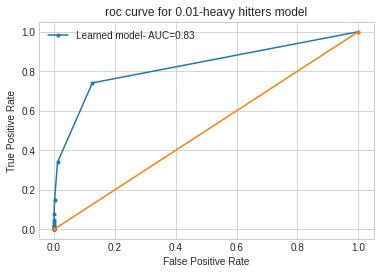

Saving plot...
Done.


<Figure size 432x288 with 0 Axes>

In [8]:
plot_roc(targets=targets, preds=preds, split='test', hh_frac=0.01)

In [20]:
# no lookup, only using learned model
LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/data/home/daniel_nlp/learning-ds/.env/lib/python3.6/site-packages/ipykernel_launcher.py -f /data/home/daniel_nlp/.local/share/jupyter/runtime/kernel-a89d89df-bab4-4cc8-9b6e-30f238917f37.json

statistics for valid data:
./nlp/true_wikicorpus_valid_concat_1.5%.npz
data #: 95483, shape (95483,)
positive ratio: 1.56197, max 948.000000, min 1.000000


statistics for test data:
./nlp/true_wikicorpus_test_concat_1.5%.npz
data #: 318278, shape (318278,)
positive ratio: 1.57415, max 8096.000000, min 1.000000


data loading time: 0.5 sec
	loss_cf 0.00	loss_rd 6.30	loss_avg 2.67
cutoff_count_min_param: bcut: 45000, # hashes 1, # buckets 55000 - loss 2.67	 time: 1.22 sec
	loss_cf 0.00	loss_rd 5.01	loss_avg 3.39	loss_cf 0.00	loss_rd 2.25	loss_avg 1.52


In [17]:
# perfect oracle
LOOKUP_DATA3=None
PERFECT_ORDER=True


lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

# plot count min

plot testing results for lookup table
plot testing results for perfect CCM
plot testing results for cutoff cmin


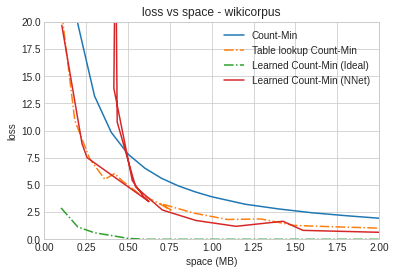

In [18]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_min_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [0.0052]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()